<a href="https://colab.research.google.com/github/MohamadMahdiDarvishi/Tensorflow/blob/main/Notebooks/Tensorflow_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convoloutional Neural Network and Computer vision with Tensorflow

In Machine Learning or more specificly computer vision we are going to write algorithms to find patterns in numbers .

## Prerquirities

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import pathlib
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model

## Binary classification

### Prepare data

we are going to work with [`101Food`](https://www.kaggle.com/datasets/dansbecker/food-101) dataset (101 classes of foods)

but we modified our data to two classes for binary classification

In [ ]:
import os

if os.path.exists("pizza_steak.zip") == False :

  # 1 . Download files
  !wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

  # 2 . unzip file
  import zipfile
  zip_ref = zipfile.ZipFile("pizza_steak.zip")
  zip_ref.extractall()
  zip_ref.close()

else :
  print("files already exists")

--2023-08-30 12:06:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 74.125.203.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M  29.5MB/s    in 4.4s    

2023-08-30 12:06:47 (23.9 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



### Inspect data (becoming one with data)

In [ ]:
!ls

pizza_steak  pizza_steak.zip  sample_data


In [ ]:
!ls pizza_steak

test  train


In [ ]:
!ls pizza_steak/train

pizza  steak


In [ ]:
# or we could do ...
os.listdir("pizza_steak/train/steak")[:3] , len(os.listdir("pizza_steak/train/steak")) # we have 750 images of steak as our training data

(['1888450.jpg', '1147047.jpg', '22080.jpg'], 750)

In [ ]:
# walk through our data
for dirpath , dirname , dirfiles in os.walk("pizza_steak") :
  print(f"in dir : [{dirpath}]  we have : {dirname} that contains : {len(dirfiles)} images")

in dir : [pizza_steak]  we have : ['train', 'test'] that contains : 0 images
in dir : [pizza_steak/train]  we have : ['steak', 'pizza'] that contains : 0 images
in dir : [pizza_steak/train/steak]  we have : [] that contains : 750 images
in dir : [pizza_steak/train/pizza]  we have : [] that contains : 750 images
in dir : [pizza_steak/test]  we have : ['steak', 'pizza'] that contains : 0 images
in dir : [pizza_steak/test/steak]  we have : [] that contains : 250 images
in dir : [pizza_steak/test/pizza]  we have : [] that contains : 250 images


**Plot random image**

In [ ]:
# finding classes names
train_dir = pathlib.Path("pizza_steak/train")
class_name = list(np.array(sorted(item.name for item in train_dir.glob("*"))))
class_name

['pizza', 'steak']

**Note :** images folder are sorted in alphabet order so we must use `sorted` insted of `list` keyword

In [ ]:
import matplotlib.image as mpimg
import random

def plot_random(target_data : str , target_class : str , data_folder) :
  # 1 . defining path
  path = pathlib.Path(data_folder + "/" + target_data + "/" + target_class)
  # 2 . chossing random index
  random_img = random.sample(list(iter((path).glob("*"))) , k = 1)
  # 3 . reading img data to tensors
  img = mpimg.imread(random_img[0])
  # 4 . visualizing
  plt.axis("off") ;
  plt.imshow(img) ;
  plt.title(target_class)
  print(f"img shape : {img.shape}")

img shape : (512, 289, 3)


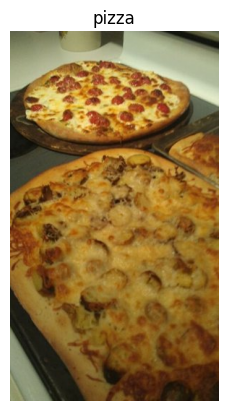

In [ ]:
plot_random("train" , "pizza" , "pizza_steak")

### Build Model

1. Preprocess data
2. Create model
3. Evaluate model
4. Improve model
5. Again , Again , Again , ...

#### 1 . Preprocess data

Turning our data into batches and make adjusting(normalizations , ...) on data

In [ ]:
# Step 1 : Create our data Generators and and make normalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1/255.0)
test_datagen = ImageDataGenerator(rescale = 1/255.0)

In [ ]:
# Step 2 : Load our data(images) from directories and turn them to batches
train_data = train_datagen.flow_from_directory(directory = "pizza_steak/train" ,
                                               seed = 42 ,
                                               shuffle = True ,
                                               class_mode = "binary",
                                               batch_size = 32,
                                               target_size = (224 , 224))
test_data = test_datagen.flow_from_directory(directory = "pizza_steak/test",
                                             seed = 42,
                                             shuffle = False,
                                             class_mode = "binary",
                                             batch_size = 32 ,
                                             target_size = (224 , 224))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
# becoming one with data
train_data , len(train_data) , len(train_data[0])

(<keras.preprocessing.image.DirectoryIterator at 0x7f8607cbb520>, 47, 2)

In [ ]:
train_data[0][0].shape , train_data[0][1].shape # 32 images and 32 lables

((32, 224, 224, 3), (32,))

#### 2 . Create Model

In [ ]:
# set random seed
tf.random.set_seed(42)

# 1 . Create model
model_0 = tf.keras.Sequential([
    tf.keras.Input(shape = (224 , 224 , 3) , name = "input_layer") ,
    tf.keras.layers.Conv2D(filters = 10,
                           kernel_size = (3,3) ,
                           strides = (1,1) ,
                           activation = tf.keras.activations.relu ,
                           padding = "valid") ,
    tf.keras.layers.Conv2D(filters = 10 ,
                           kernel_size = 3 ,
                           strides = 1,
                           activation = tf.keras.activations.relu ,
                           padding = "valid") ,
    tf.keras.layers.MaxPool2D(pool_size= 2,
                              padding = "valid") ,
    tf.keras.layers.Conv2D(10 , 3 , activation = "relu") ,
    tf.keras.layers.Conv2D(10 , 3 , activation = "relu") ,
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten() ,
    tf.keras.layers.Dense(1 , activation = "sigmoid" , name = "output_layer")
] , name = "model_0")

# 2 . Compile model
model_0.compile(loss = tf.keras.losses.binary_crossentropy ,
                optimizer = tf.keras.optimizers.Adam() ,
                metrics = ["accuracy"])

# 3 . Fit model
results_0 = model_0.fit(x = train_data ,
                        steps_per_epoch = len(train_data) ,
                        epochs = 5 ,
                        validation_data = test_data ,
                        validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 131s 3s/step - loss: 0.6171 - accuracy: 0.6727 - val_loss: 0.4004 - val_accuracy: 0.8340
Epoch 2/5
47/47 [==============================] - 172s 4s/step - loss: 0.4609 - accuracy: 0.8000 - val_loss: 0.3801 - val_accuracy: 0.8460
Epoch 3/5
47/47 [==============================] - 142s 3s/step - loss: 0.4180 - accuracy: 0.8267 - val_loss: 0.3571 - val_accuracy: 0.8480
Epoch 4/5
47/47 [==============================] - 137s 3s/step - loss: 0.3947 - accuracy: 0.8280 - val_loss: 0.3342 - val_accuracy: 0.8540
Epoch 5/5
47/47 [==============================] - 137s 3s/step - loss: 0.3844 - accuracy: 0.8360 - val_loss: 0.3100 - val_accuracy: 0.8760


#### 3 . Evaluate our model

as ploting loss and accuracy curves in one figure may bring problems

In [ ]:
def plot_loss_acc(results) :
  plt.figure(figsize = (15,5))
  plt.subplot(1 , 2 , 1)
  plt.plot(pd.DataFrame(results.history["val_loss"]) , label = "val_loss") ;
  plt.plot(pd.DataFrame(results.history["loss"]) , label = "loss") ;
  plt.legend() ;
  plt.subplot(1 , 2 , 2)
  plt.plot(pd.DataFrame(results.history["accuracy"]) , label = "accuracy")
  plt.plot(pd.DataFrame(results.history["val_accuracy"]) , label = "val_accuracy")
  plt.legend()

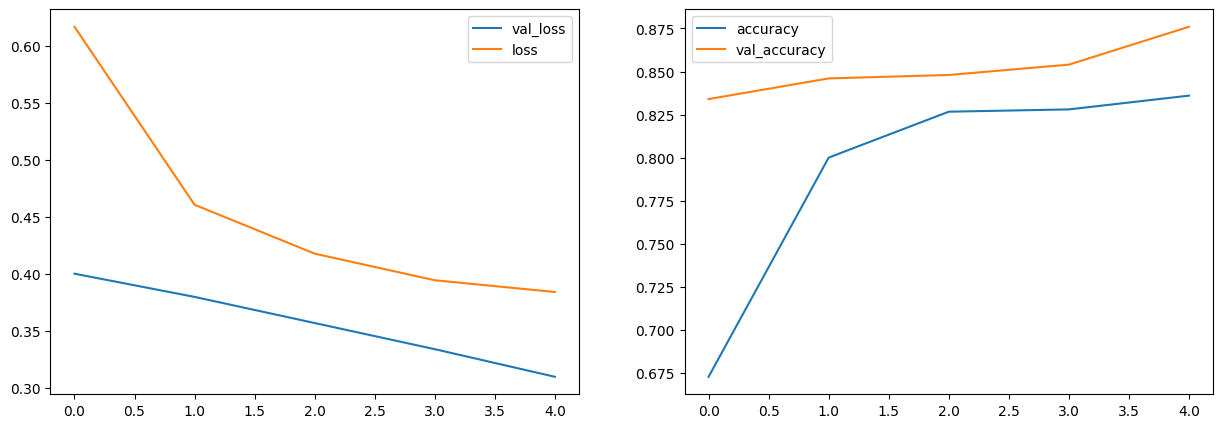

In [ ]:
plot_loss_acc(results_0)

**❗ Attention**

1. **Note ✅**

>>When a model's **validation loss starts to increase**, it's likely that the model is **overfitting** the training dataset. This means, it's learning the patterns in the training dataset *too well* and thus the model's ability to generalize to unseen data will be diminished.

2. **Note ✅**

>>Ideally the two loss curves (training and validation) will be very similar to each other (training loss and validation loss decreasing at similar rates), when there are large differences your model may be **overfitting**.

**⏰ Appendix**

the notes that are mentioned in this comment box are inspired by daniel brouke [third note book from learning Tensorflow Course](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/video_notebooks/03_convolutional_neural_networks_with_tensorflow_video.ipynb)

**⚡ Ways to reduce overfitting**

1. Add data augmentation
2. Add Regularization layers
> *   increase number of conv layers
> *   increase number of conv filters
> *   Add another Dese layer to output
3. Add more data


❗ Reminder

few ways to improve our model

✅ performe more data for our model train

✅ more epochs

✅ Find ideal learning rate

✅ model mainipulation (change the number of layers , filters and etc.)

✅ Use transfer learning to leverage what another image model has learn and adjust it for our own use case

▶ **Conclusion**

---

as we have enough number of `Conv2D` layers and enough filters or maybe data for training we choose `Data Augmentation` for Reeducing **overfitting**

#### 4 . Improve model
(Adding Data Augmentation)


❓ **Question**

what is data augmentation ?

---

Data augmentation is the process of altering our training data, leading it to have more diversity and in turn allowing our models to learn more generalizable (hopefully) patterns. Altering might mean adjuting the rotation of an image, flipping it, cropping it or something similar.

---
**Note**

Data augmentation is usually only performed on the training data.

In [ ]:
# train
train_datagen_aug = ImageDataGenerator(rescale = 1/255.0 ,
                                       rotation_range = 0.2 ,
                                       width_shift_range = 0.2,
                                       height_shift_range = 0.2 ,
                                       shear_range = 0.2 ,
                                       zoom_range = 0.2 ,
                                       horizontal_flip = True)
# test (just for remembering)
test_datagen = ImageDataGenerator(rescale = 1/255.0)

In [ ]:
train_data_aug = train_datagen_aug.flow_from_directory(directory = "pizza_steak/train" ,
                                                       target_size = (224,224) ,
                                                       class_mode = "binary" ,
                                                       shuffle = True ,
                                                       seed = 42 ,
                                                       batch_size = 32)
test_data = test_datagen.flow_from_directory(directory = "pizza_steak/test",
                                             target_size = (224,224) ,
                                             class_mode = "binary" ,
                                             shuffle = False ,
                                             seed = 42 ,
                                             batch_size = 32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


<ipython-input-39-a701158bafff>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


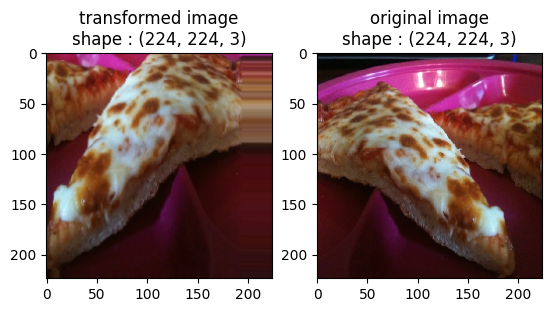

In [ ]:
# visualize a random image
# 1 . pick random number
random_batch = random.randint(0 , len(train_data_aug))
random_image = random.randint(0 , len(test_data))
# 2 . visualize
plt.axis("off")
plt.subplot(1,2,1)
plt.imshow(train_data_aug[random_batch][0][random_image]) ;
plt.title(f"transformed image\nshape : {(train_data_aug[random_batch][0][random_image]).shape}") ;
plt.subplot(1,2,2)
plt.imshow(train_data[random_batch][0][random_image]) ;
plt.title(f"original image\nshape : {(train_data[random_batch][0][random_image]).shape}") ;

In [ ]:
# set random seed
tf.random.set_seed(42)

# 1 . Create model
model_1 = tf.keras.Sequential([
    tf.keras.Input(shape = (224 , 224 , 3) , name = "input_layer") ,
    tf.keras.layers.Conv2D(10 , 3 , activation = "relu") ,
    tf.keras.layers.Conv2D(10 , 3 , activation = "relu") ,
    tf.keras.layers.MaxPool2D(2) ,
    tf.keras.layers.Conv2D(10 , 3 , activation = "relu") ,
    tf.keras.layers.Conv2D(10 , 3 , activation = "relu") ,
    tf.keras.layers.MaxPool2D(2) ,
    tf.keras.layers.Flatten() ,
    tf.keras.layers.Dense(1 , activation = "sigmoid" , name = "output_layer")
] , name = "model_1")

# 2 . Compile model
model_1.compile(loss = tf.keras.losses.binary_crossentropy ,
                optimizer = tf.keras.optimizers.Adam() ,
                metrics = ["accuracy"])

results_1 = model_1.fit(x = train_data_aug ,
                        epochs = 5 ,
                        steps_per_epoch = len(train_data_aug) ,
                        validation_data = test_data ,
                        validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 158s 3s/step - loss: 0.6153 - accuracy: 0.6667 - val_loss: 0.4641 - val_accuracy: 0.7960
Epoch 2/5
47/47 [==============================] - 147s 3s/step - loss: 0.5350 - accuracy: 0.7347 - val_loss: 0.4303 - val_accuracy: 0.8140
Epoch 3/5
47/47 [==============================] - 153s 3s/step - loss: 0.5041 - accuracy: 0.7693 - val_loss: 0.4134 - val_accuracy: 0.8180
Epoch 4/5
47/47 [==============================] - 153s 3s/step - loss: 0.4890 - accuracy: 0.7687 - val_loss: 0.3655 - val_accuracy: 0.8500
Epoch 5/5
47/47 [==============================] - 151s 3s/step - loss: 0.4996 - accuracy: 0.7640 - val_loss: 0.4200 - val_accuracy: 0.8140


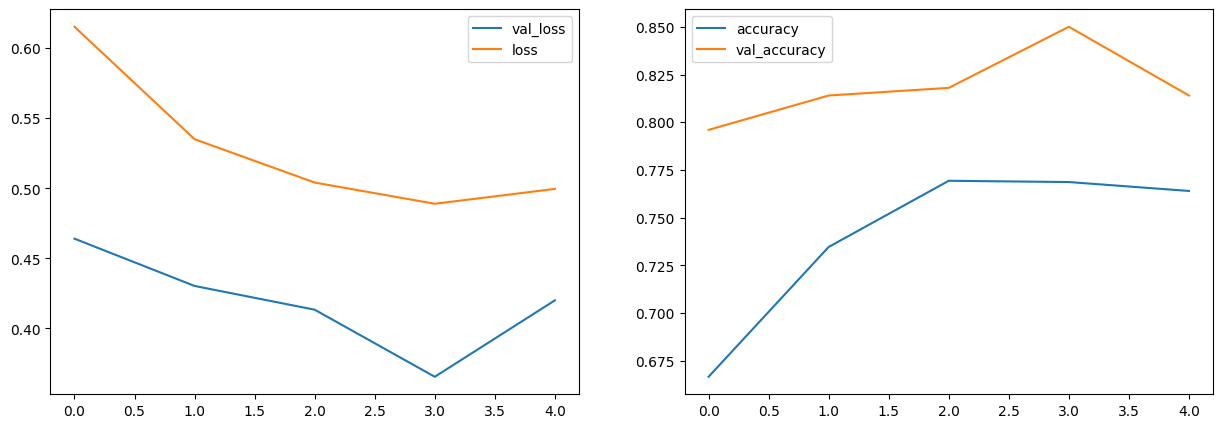

In [ ]:
plot_loss_acc(results=results_1)

#### 5 . Make Prediction

In [ ]:
def make_prediction(path , model , classes , target_size = [224,224]) :

  # 1 . Read image
  image = tf.io.read_file(path)
  # 2 . decode image file
  image_decoded = tf.image.decode_image(image)
  # 3 . resize image
  image_decoded = tf.image.resize(image_decoded , size = target_size)
  # 4 . normalize image
  image_decoded = image_decoded/255.0
  # 5 . make prediction
  pred = model.predict(tf.expand_dims(image_decoded , axis = 0))
  # 6 . find class
  if len(classes) == 2 :
    found_class = class_name[int(tf.round(pred))]
  if len(classes) > 2 :
    found_class = class_name[int(tf.argmax(pred , axis = 1))]
  # 7 . visualize
  plt.title(f"prediction : {found_class}") ;
  plt.imshow(image_decoded) ;
  plt.axis("off") ;

1/1 [==============================] - 0s 145ms/step


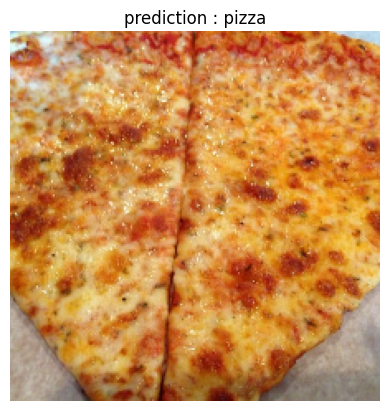

In [ ]:
make_prediction(path = "pizza_steak/test/pizza/3650727.jpg" ,
                model = model_1 ,
                classes = class_name)

# Multi-class Image Classification

**Steps :**

▶ become one with data

▶ preproccess with data

▶ create and fit model

▶ evaluate model

▶ Improve model

## 0 . Prerequirities

In [ ]:
# Imports
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import pathlib
from sklearn.metrics import confusion_matrix
import os
import random

## 1 . Prepare data

become one with data

In [ ]:
# Download Data
!wget  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
!rm -r __MACOSX
# Unzip data
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip")
zip_ref.extractall()
zip_ref.close()

--2023-08-30 12:50:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.187.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  29.1MB/s    in 18s     

2023-08-30 12:51:13 (27.6 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]

rm: cannot remove '__MACOSX': No such file or directory


In [ ]:
# Find Classes
classes_name = sorted(os.listdir("10_food_classes_all_data/train"))

In [ ]:
# train and test directories
train_dir = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

img shape : (512, 512, 3)


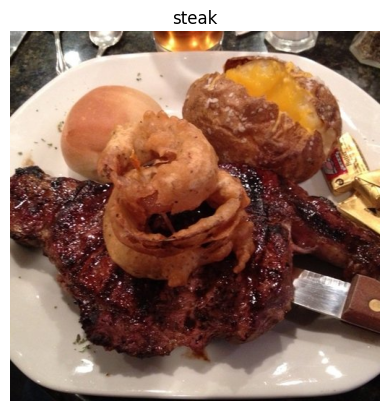

In [ ]:
# visualize a random image
plot_random(target_class=random.choice(classes_name) ,
            target_data = "test" ,
            data_folder = "10_food_classes_all_data")

## 2 . Preprocces data

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train data generator
train_data_gen = ImageDataGenerator(rescale = 1/255.0 ,
                                    width_shift_range = 0.2 ,
                                    height_shift_range = 0.2 ,
                                    rotation_range = 0.2 ,
                                    shear_range = 0.2 ,
                                    horizontal_flip = True)

# test data generator
test_data_gen = ImageDataGenerator(rescale = 1/255.0)

In [ ]:
# train data
train_data = train_data_gen.flow_from_directory(directory = train_dir ,
                                                target_size = (224 , 224 ) ,
                                                class_mode = "categorical" ,
                                                batch_size = 32 ,
                                                shuffle = True ,
                                                seed = 42)

# test_data
test_data = test_data_gen.flow_from_directory(directory = test_dir ,
                                              target_size = (224 ,224),
                                              class_mode = "categorical" ,
                                              batch_size = 32 ,
                                              shuffle = False ,
                                              seed = 42)



Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## 3 . Create model

In [ ]:
# set random seed
tf.random.set_seed(42)

# Create  model
model_2 = tf.keras.Sequential([
    tf.keras.Input(shape = (224 , 224 , 3) , name = "input_layer") ,
    tf.keras.layers.Conv2D(10 , 3 , activation = "relu") ,
    tf.keras.layers.Conv2D(10 , 3 , activation = "relu") ,
    tf.keras.layers.MaxPool2D(2) ,
    tf.keras.layers.Conv2D(10 , 3 , activation = "relu") ,
    tf.keras.layers.Conv2D(10 , 3 , activation = "relu") ,
    tf.keras.layers.MaxPool2D(2) ,
    tf.keras.layers.Conv2D(10 , 3 , activation = "relu") ,
    tf.keras.layers.Conv2D(10 , 3 , activation = "relu") ,
    tf.keras.layers.MaxPool2D(2) ,
    tf.keras.layers.Flatten() ,
    tf.keras.layers.Dense(10 , activation = "softmax" , name = "output_layer")
] , name = "model_2")

# compile model
model_2.compile(loss = tf.keras.losses.categorical_crossentropy ,
                optimizer = tf.keras.optimizers.Adam() ,
                metrics  = ["accuracy"])

# fit model
results_2 = model_2.fit( epochs = 5 ,
                        x = train_data ,
                        steps_per_epoch = len(train_data)  ,
                        validation_data = test_data ,
                        validation_steps = len(test_data))

Epoch 1/5
235/235 [==============================] - 758s 3s/step - loss: 2.2283 - accuracy: 0.1639 - val_loss: 2.1260 - val_accuracy: 0.2176
Epoch 2/5
235/235 [==============================] - 767s 3s/step - loss: 2.1292 - accuracy: 0.2203 - val_loss: 1.9825 - val_accuracy: 0.3156
Epoch 3/5
 24/235 [==>...........................] - ETA: 10:10 - loss: 2.0970 - accuracy: 0.2344

KeyboardInterrupt: ignored

## 4 . Evaluate model

In [ ]:
pd.DataFrame(results_2).plot() ;

In [ ]:
# make prediction
make_prediction(model = model_2 ,
                path = "" ,
                classes = classes_names)

In [ ]:
# save model
model_2.save("multi-class classification")

In [ ]:
# load model
loaded_model = tf.keras.models.load_model("multi-class classification")

In [ ]:
# evaluate model
loaded_model.evaluate(test_data)

⚡ ❗ ✌ ▶ ❓ ⚛ 🔔 💣